In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.search.greedy_search_strategy import GreedySearchStrategy
from lib.model.search.beam_search_strategy import BeamSearchStrategy, EndCriteria
from lib.model.attention_layer import AttentionLayer

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import show_sample
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj
from lib.utils.sequencer import Sequencer

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

from lib.model.prediction_inspector import PredictionInspector

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset_name='8k'
# dataset_name='30k'

embedding_vector_dim = 300
embedding_token_count = 6
embedding_token_count = 840
embeding_name = f'{embedding_token_count}B.{embedding_vector_dim}d'
word_embedding_path = f'./dataset/glove.{embeding_name}.txt'



dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'

image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{embeding_name}.pkl'

line_separator = { 
    '8k': r'#[0-9]',
    '30k': r'\| [0-9]\|'
}
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{val_loss:.4f}__acc_{val_rmse:.4f}.h5'

In [4]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [5]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.16, shuffle=True)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.22, shuffle=True)

print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 6796, Val: 1010, Test: 285


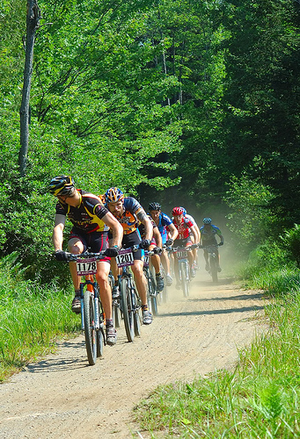

,Description
0,group of bicyclist ride down path in an off road race
1,group of biker ride through the wood
2,group of person be ride bicycle in race
3,biker race through forest
4,many bicyclist race along dirt road


In [6]:
show_sample(train_samples[0])

In [7]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)

image_features = load_obj(image_features_path)
print(image_features[0])
image_features = dict(image_features)

('./dataset/8k/images/1305564994_00513f9a5b.jpg', array([ 0.06508789,  0.03218704,  0.02376981, ...,  0.38368699,
        0.19910596,  0.23510453], dtype=float32))


In [8]:
min_occurs=10

vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [9]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [10]:
len(word_to_index)

1593

In [11]:
dataset.max_desc_len()

174

In [12]:
if not os.path.isfile(descrption_embedding_path):
    embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)
    embedding_matrix = embedding_generator.generate(word_to_index)
    save_obj(descrption_embedding_path, embedding_matrix)

embedding_matrix = load_obj(descrption_embedding_path)
len(embedding_matrix)

1593

In [13]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512)(img_branch)
    img_branch = LeakyReLU(alpha=0.3)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512)(decoder)
    decoder = LeakyReLU(alpha=0.3)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

In [14]:
# 1ª Train:
epochs=10
lr=0.001
batch_size = 12

# 2ª Train:
#epochs=10
#lr=0.0001
#batch_size = 20

steps_per_epoch=len(train_samples)/batch_size

In [15]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

In [16]:
callbacks = [
    ModelCheckpoint(
        weights_file_path_patern,
        monitor='val_loss', 
        verbose=1,
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto',
        period=1
    ),
    AdamLearningRateTracker(evaluate_interval=105),
    ReduceLROnPlateau(
        monitor  = 'val_loss',
        factor   = 0.2,
        patience = 1
    ),
    MetricsPlotter(
        val_generator, 
        plot_interval=100, 
        evaluate_interval=100, 
        batch_size=batch_size
    )
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Metrics: ['loss', 'rmse']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Feature (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
Description_Sequence (InputLaye (None, 174)          0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           Image_Feature[0][0]              
____________________________________________________________________________________________

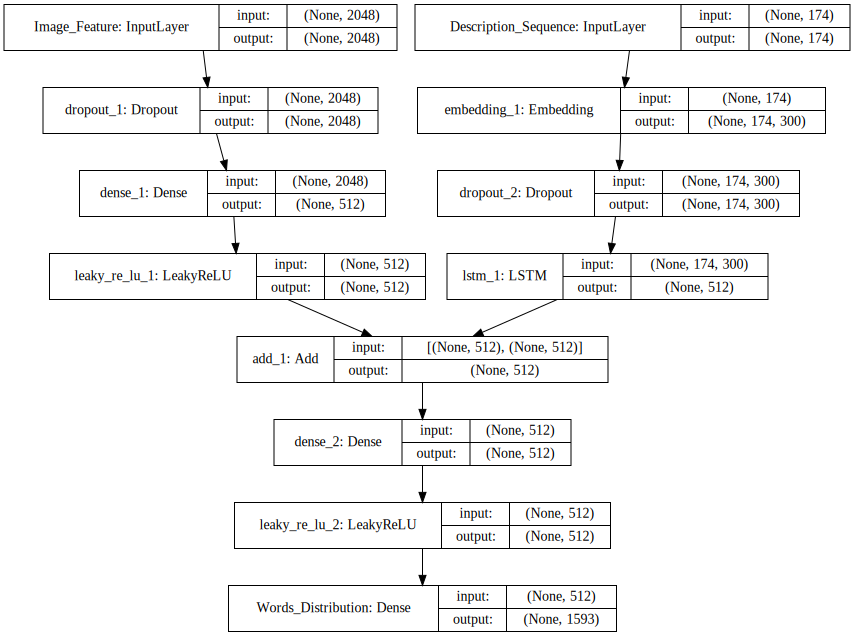

In [17]:
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=lr))
model.show()    

In [18]:
model.load(f'{weights_path}/weights__epoch_01__loss_2.3339__acc_0.0210.h5')

# model.fit(train_generator, val_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Load weights from weights/8k/weights__epoch_01__loss_2.3339__acc_0.0210.h5


In [43]:
sequencer = Sequencer(
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    max_seq_len=dataset.max_desc_len()
)

search = BeamSearchStrategy(
    model=model,
    sequencer=sequencer,
    seq_prefix='$',
    seq_postfix='#',
    end_criteria=EndCriteria().at_lest_n_end_with(n=5, word='#'),
    k=5
)

def random_sample(samples): return samples[random.randint(0, len(samples)-1)]

inspector = PredictionInspector(search, image_features, dataset.descriptions())

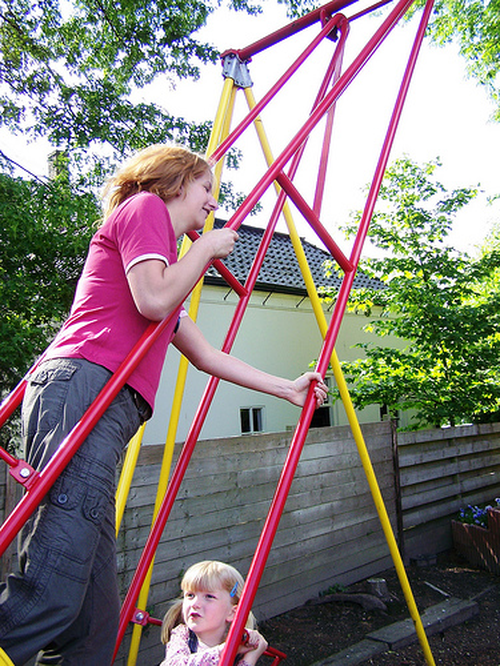

,Predicted Description,Description Score (⟱ best),WMD Mean,WMD (⟰ best),Sample Description
0,child play on swing,0.0751576785,0.6203824156,0.6754796651,woman play with play equipment while child look on
1,,,,0.6227167452,two kid play on playground equipment
2,,,,0.6045525587,woman and girl be swing on red swing
3,,,,0.6002431022,teenage girl and little girl play on pink toy
4,,,,0.5989200069,child on red and yellow swing set
5,little girl play on swing,0.2800077470,0.6351899106,0.7153815307,teenage girl and little girl play on pink toy
6,,,,0.6664173380,woman and girl be swing on red swing
7,,,,0.6072770185,woman play with play equipment while child look on
8,,,,0.5965703133,two kid play on playground equipment
9,,,,0.5903033522,child on red and yellow swing set


In [44]:
inspector.inspect(random_sample(test_samples))

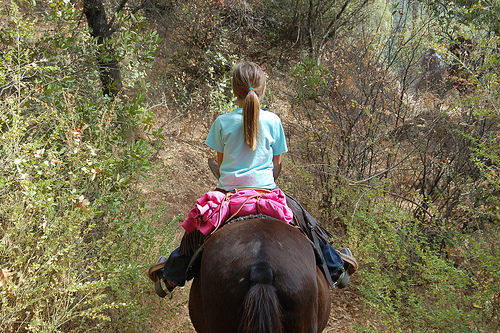

,Predicted Description,Description Score (⟱ best),WMD Mean,WMD (⟰ best),Sample Description
0,child be ride horse through the wood,0.9224241431,0.6743620821,0.7294974463,little girl be ride horse in the wood
1,,,,0.7033075013,girl ride on brown horse down forest path
2,,,,0.6954756564,young girl ride on horse through trail
3,,,,0.6528810079,girl be ride horseback
4,,,,0.5906487988,view from behind of girl with blond ponytail ride dark brown horse
5,child be ride horse in the wood,1.2343086509,0.6743620821,0.7294974463,little girl be ride horse in the wood
6,,,,0.7033075013,girl ride on brown horse down forest path
7,,,,0.6954756564,young girl ride on horse through trail
8,,,,0.6528810079,girl be ride horseback
9,,,,0.5906487988,view from behind of girl with blond ponytail ride dark brown horse


In [45]:
inspector.inspect(random_sample(test_samples))

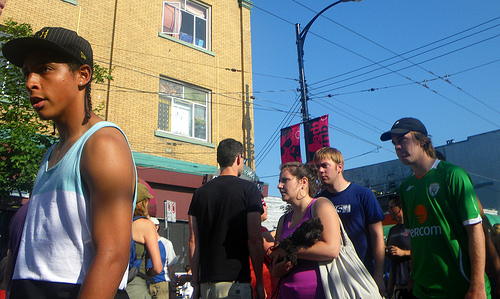

,Predicted Description,Description Score (⟱ best),WMD Mean,WMD (⟰ best),Sample Description
0,man in red shirt be stand in front of crowd of person,0.0037168011,0.5663852714,0.6788662852,group of person stand in front of yellow building
1,,,,0.5723309691,crowd of person be walk down city street
2,,,,0.5442409746,group person walk around the corner near brick building
3,,,,0.5202661375,people gather together outdoors
4,,,,0.5162219905,people walk near brick building
5,man in red shirt be stand in front of brick building,0.0048422945,0.5686590939,0.6734281075,group of person stand in front of yellow building
6,,,,0.5697706922,people walk near brick building
7,,,,0.5684131389,group person walk around the corner near brick building
8,,,,0.5189128990,crowd of person be walk down city street
9,,,,0.5127706321,people gather together outdoors


In [ ]:
inspector.inspect(random_sample(test_samples))

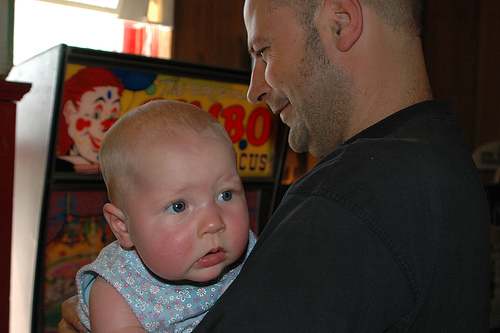

,Predicted Description,Description Score (⟱ best),WMD Mean,WMD (⟰ best),Sample Description
0,little boy in blue shirt hold baby,0.0442139724,0.6643084969,0.7705712880,closeup of man hold baby wear blue shirt
1,,,,0.7436794614,man hold chubby baby with pink cheek and blue shirt
2,,,,0.6909167875,man in black hold baby
3,,,,0.5917285966,man be hold baby near carnival game
4,,,,0.5246463508,ever since his baby girl start come to an arcade with him dad enjoy watch others play his favorite pinball game
5,little boy in red shirt hold baby,0.0509843118,0.6540629205,0.7455406030,closeup of man hold baby wear blue shirt
6,,,,0.7236166977,man hold chubby baby with pink cheek and blue shirt
7,,,,0.6870284669,man in black hold baby
8,,,,0.5917266549,man be hold baby near carnival game
9,,,,0.5224021799,ever since his baby girl start come to an arcade with him dad enjoy watch others play his favorite pinball game


In [ ]:
inspector.inspect(random_sample(test_samples))

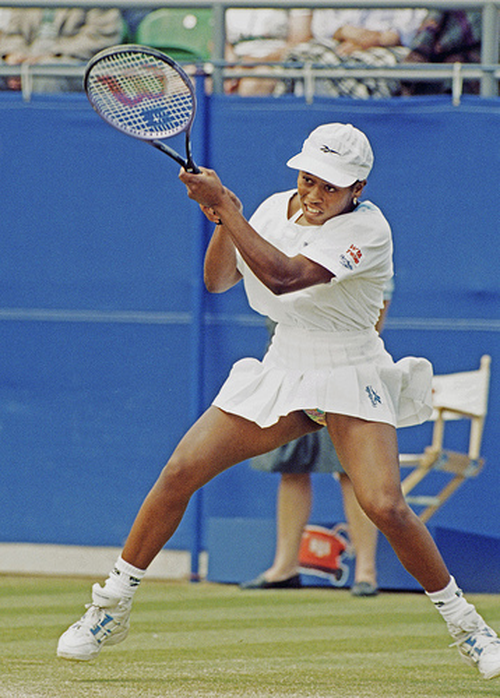

,Predicted Description,Description Score (⟱ best),WMD Mean,WMD (⟰ best),Sample Description
0,tennis player hit the ball to,0.0001679072,0.6600053888,0.7893274445,female tennis player swing for the ball
1,,,,0.6768837201,tennis player dress in white swing racket
2,,,,0.6593522682,woman swing tennis racket on the court
3,,,,0.5975379577,woman be dress in all white swing tennis racket
4,,,,0.5769255533,woman intensely play tennis in an allwhite outfit
5,tennis player hit the ball,0.0001809629,0.6600053888,0.7893274445,female tennis player swing for the ball
6,,,,0.6768837201,tennis player dress in white swing racket
7,,,,0.6593522682,woman swing tennis racket on the court
8,,,,0.5975379577,woman be dress in all white swing tennis racket
9,,,,0.5769255533,woman intensely play tennis in an allwhite outfit


In [ ]:
inspector.inspect(random_sample(test_samples))

In [ ]:
inspector.inspect(random_sample(test_samples))

In [ ]:
inspector.inspect(random_sample(test_samples))

In [ ]:
inspector.inspect(random_sample(test_samples))

In [ ]:
inspector.inspect(random_sample(test_samples))

In [ ]:
inspector.inspect(random_sample(test_samples))

In [ ]:
inspector.inspect(random_sample(test_samples))